In [ ]:
import sys
from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Concatenate, Dropout, Dense, Embedding, Flatten, GlobalMaxPooling1D, Input, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import spacy
from spacy.lang.en import English
import string
import emoji

import pandas as pd
import numpy as np
import re
import pickle

import matplotlib.pyplot as plt

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
data = pd.read_csv('../input/goemotions/nlpc.csv')

In [ ]:
data.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,1,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,1


In [ ]:
data.isna().sum()

text        0
anger       0
disgust     0
fear        0
joy         0
sadness     0
surprise    0
neutral     0
dtype: int64

In [ ]:
len(data.columns)

8

In [ ]:
labels = data[['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']]
labels = labels.astype('float')

In [ ]:
nlp = English()

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}


In [ ]:
def remove_stop(sen):
  my_sen = nlp(sen)

  token_list = []
  for token in my_sen:
    token_list.append(token.text)
  
  filtered_sen = []
  for word in token_list:
    lexeme = nlp.vocab[word]
    if lexeme.is_stop == False:
      filtered_sen.append(word)
  
  return ' '.join(filtered_sen)

In [ ]:
def clean_text(sen):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    sentence = emoji.demojize(sen)
    
    sentence = re.sub(r'\:(.*?)\:','',sentence)
    sentence = str(sentence).lower()    #Making Text Lowercase
    
    sentence = re.sub('\[.*?\]', '', sentence)
    
    # Remove numbers
    #sentence = re.sub('[0-9]', ' ', sentence)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence)
    
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    return sentence

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_stop(text)
    return text


def test(text):
    text = clean_text(text)
    return text

In [ ]:
X = []
sentences = list(data["text"])
for sen in sentences:
    X.append(text_preprocessing_pipeline(sen))

y = labels.values

In [ ]:
len(y)

76654

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Saving the Tokenizer for later Use
with open('./tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
"""
Building a custom dictionary for all the words in my training dataset
The dictionary is a collection of floats that represent different words as per the Glove 6Billion tokens 100 dimension dictionary
"""
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('../input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
print(embedding_matrix.shape)
print(vocab_size)

(32464, 200)
32464


In [ ]:
deep_inputs = Input(shape=(maxlen, ), name='input')
embedding_layer = Embedding(vocab_size, 200, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False)(deep_inputs)
LSTM_Bi_Layer_1 = Bidirectional(LSTM(2048, name='lstm_1'))(embedding_layer)
dropout = Dropout(0.4, name='drop_1')(LSTM_Bi_Layer_1)
dense_layer_1 = Dense(1024, activation='relu', name='dense_1')(dropout)
dropout1 = Dropout(0.3, name='drop_2')(dense_layer_1)
dense_layer_2 = Dense(512, activation='relu', name='dense_2')(dropout1)
dense_layer_3 = Dense(256, activation='relu', name='dense_3')(dense_layer_2)
dense_layer_4 = Dense(128, activation='relu', name='dense_4')(dense_layer_3)
dense_layer_5 = Dense(7, activation='sigmoid', name='dense_out')(dense_layer_4)
model = Model(inputs=deep_inputs, outputs=dense_layer_5)

2021-12-12 20:17:04.484532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 20:17:04.485702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 20:17:04.486381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 20:17:04.487146: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 200)          6492800   
_________________________________________________________________
bidirectional (Bidirectional (None, 4096)              36847616  
_________________________________________________________________
drop_1 (Dropout)             (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
drop_2 (Dropout)             (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("./smodel.h5", save_best_only=True, monitor='val_loss')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.1, callbacks=[checkpoint_cb, early_stopping_cb])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
2021-12-12 20:17:30.720862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-12-12 20:17:31.541466: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1833/1833 [==============================] - 593s 322ms/step - loss: 0.3512 - acc: 0.3961 - val_loss: 0.3474 - val_acc: 0.3841
Epoch 2/50
1833/1833 [==============================] - 610s 333ms/step - loss: 0.3036 - acc: 0.4977 - val_loss: 0.2783 - val_acc: 0.5485
Epoch 3/50
1833/1833 [==============================] - 610s 333ms/step - loss: 0.2680 - acc: 0.5633 - val_loss: 0.2605 - val_acc: 0.5872
Epoch 4/50
1833/1833 [==============================] - 612s 334ms/step - loss: 0.2643 - acc: 0.5688 - val_loss: 0.2911 - val_acc: 0.5052
Epoch 5/50
1833/1833 [==============================] - 613s 334ms/step - loss: 0.2722 - acc: 0.5518 - val_loss: 0.2577 - val_acc: 0.5824
Epoch 6/50
1833/1833 [==============================] - 592s 323ms/step - loss: 0.2464 - acc: 0.6077 - val_loss: 0.2467 - val_acc: 0.6064
Epoch 7/50
1833/1833 [==============================] - 615s 335ms/step - loss: 0.2385 - acc: 0.6226 - val_loss: 0.2459 - val_acc: 0.6016
Epoch 8/50
1833/1833 [=======================

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

360/360 [==============================] - 38s 106ms/step - loss: 0.2411 - acc: 0.6192


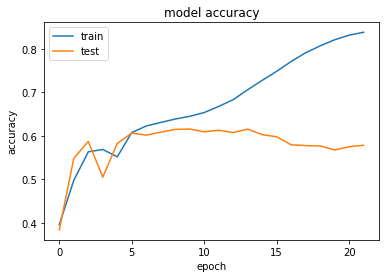

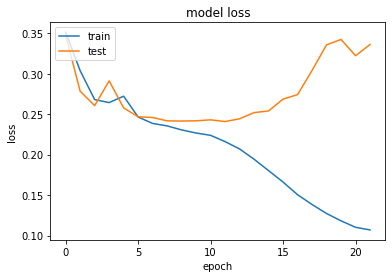

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.savefig('./sen_accuracy.png', dpi=1000, bbox_inches="tight")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.savefig('./sen_loss.png', dpi=1000, bbox_inches="tight")
plt.show()